## **演示0704：模型效果的影响因素**

### **案例1：Feature Scaling问题**
>  
在多变量情况下，各个变量的值域可能有很大区别。例如，$x1$的值域可能在(1,10)之间，而$x2$的值域可能(1,10000)之间。值域差异过大，很容易造成在计算过程中溢出或无法收敛。而通过对数据进行**归一化**(Normalization)处理，可以较好的解决这个问题  
* 查看【house_price.csv】文件中的数据
 ![](../images/070401.png)  
 * Area：房屋面积；Rooms：房间数；Price：房屋出售价格。其中Area和Rooms是自变量；Price是因变量
 * Area的值一般在"数千"这个级别上，而Rooms则是个位数，值域差异明显
* 归一化方法：
 * 有多种种归一化方法，一般可采用下列办法： $x=\dfrac{x - \bar x}{std(x)}$
 * 其中，$\bar x$该列数据的平均值，$std(x)$是该列数据的标准差

> **方法1：使用sklearn.linear_model.LinearRegression处理**  
无需对自变量进行归一化处理，也能得到良好的结果。针对训练数据的R方约为0.73

In [1]:
''' 使用LinearRegression，没有进行归一化预处理 '''

import numpy as np
from sklearn.linear_model import LinearRegression

trainData = np.loadtxt(open('house_price.csv', 'r'), delimiter=",",skiprows=1)
xTrain = np.array(trainData[:, 0:2])
yTrain = np.array(trainData[:, 2])

xTrain = np.c_[xTrain, np.ones(len(xTrain))]

model = LinearRegression()
model.fit(xTrain, yTrain)
print("LinearRegression计算R方：", model.score(xTrain, yTrain))

LinearRegression计算R方： 0.7329450180289143


In [2]:
''' 使用LinearRegression，进行归一化预处理 '''

import numpy as np
from sklearn.linear_model import LinearRegression

def normalizeData(X):
    # 每列(每个Feature)分别求出均值和标准差，然后与X的每个元素分别进行操作
    return (X - X.mean(axis=0))/X.std(axis=0)         

trainData = np.loadtxt(open('house_price.csv', 'r'), delimiter=",",skiprows=1)
xTrain = np.array(trainData[:, 0:2])
yTrain = np.array(trainData[:, 2])
xTrain = normalizeData(xTrain)  

xTrain = np.c_[xTrain, np.ones(len(xTrain))]        # 归一化完成后再添加intercept item列

model = LinearRegression()
model.fit(xTrain, yTrain)
print("LinearRegression计算R方：", model.score(xTrain, yTrain))

LinearRegression计算R方： 0.7329450180289141


> **方法2：使用自定义的批量梯度下降法**
 * 在未对自变量归一化处理的情况下，运算出现异常，无法收敛
 * 归一化处理后，能够得到与LinearRegression类似的结果

In [3]:
''' 使用自定义BGD，未作归一化处理，可能无法收敛 '''

import numpy as np
import bgd_resolver  

def costFn(theta, X, y):
    temp = X.dot(theta) - y
    return (temp.T.dot(temp)) / (2 * len(X))

def gradientFn(theta, X, y): 
    return (X.T).dot(X.dot(theta) - y) / len(X)

trainData = np.loadtxt(open('house_price.csv', 'r'), delimiter=",",skiprows=1)
xTrain = np.array(trainData[:, 0:2])
yTrain = np.array(trainData[:, 2])

xTrain = np.c_[xTrain, np.ones(len(xTrain))]

init_theta = np.random.randn(xTrain.shape[1])
# 如果数据不进行Normalize，则下面的梯度算法有可能不收敛
theta = bgd_resolver.batch_gradient_descent(costFn, gradientFn, init_theta, xTrain, yTrain)
rsquare = bgd_resolver.batch_gradient_descent_rsquare(theta, xTrain, yTrain)
print("梯度下降法计算R方：", rsquare)

/mnt/c/Users/iahuo/Desktop/Apps/ML365/07_LinearRegression/bgd_resolver.py:17: RuntimeWarning: invalid value encountered in double_scalars
  if abs(target_value - next_target_value) < tolerance:
/mnt/c/Users/iahuo/Desktop/Apps/ML365/07_LinearRegression/bgd_resolver.py:15: RuntimeWarning: invalid value encountered in subtract
  next_W = W - gradient * learning_rate


50000次循环后，计算仍未收敛
梯度下降法计算R方： nan


In [4]:
''' 使用自定义BGD，作归一化处理 '''

import numpy as np
import bgd_resolver

def normalizeData(X):
    # 每列(每个Feature)分别求出均值和标准差，然后与X的每个元素分别进行操作
    return (X - X.mean(axis=0))/X.std(axis=0)         

def costFn(theta, X, y):
    temp = X.dot(theta) - y
    return (temp.T.dot(temp)) / (2 * len(X))

def gradientFn(theta, X, y): 
    return (X.T).dot(X.dot(theta) - y) / len(X)

trainData = np.loadtxt(open('house_price.csv', 'r'), delimiter=",",skiprows=1)
xTrain = np.array(trainData[:, 0:2])
yTrain = np.array(trainData[:, 2])
xTrain = normalizeData(xTrain)

xTrain = np.c_[xTrain, np.ones(len(xTrain))]

init_theta = np.random.randn(xTrain.shape[1])
# 如果数据不进行Normalize，则下面的梯度算法有可能不收敛
theta = bgd_resolver.batch_gradient_descent(costFn, gradientFn, init_theta, xTrain, yTrain)
rsquare = bgd_resolver.batch_gradient_descent_rsquare(theta, xTrain, yTrain)
print("梯度下降法计算R方：", rsquare)

循环 31206 次后收敛
梯度下降法计算R方： 0.7329450180286867


### **案例2：学习速率(learning rate)对计算的影响**
>  
* 一般情况下，学习速率越小，其收敛的可能性越大（不容易因为步长过大，而“错过”极值点），但是需要更多次循环才能到达极值点。
* 学习速率越大，能够朝着极值点更快前进，但有可能因错过极值点而造成无法收敛
* 在实际的梯度下降算法中，会先选择一个较大的learning rate，随着不断逼近极值点，逐渐减小learning rate。  
>  
下面的例子演示了，如果设置过大的学习速率，会导致计算不收敛

In [5]:
''' 测试learning rate过大的问题 '''

import numpy as np
import matplotlib.pyplot as plt
import bgd_resolver

def costFn(theta, X, y):                                # 定义线性回归的成本函数
    temp = X.dot(theta) - y
    return temp.dot(temp) / (2*len(X))

def gradientFn(theta, X, y):                            # 根据成本函数，分别对x0和x1求导数(梯度)
    return (X.T).dot(X.dot(theta) - y) / len(X)  

xTrain = np.array([6, 8, 10, 14, 18])[:, np.newaxis]
yTrain = np.array([7, 9, 13, 17.5, 18])
xTrain_ext = np.c_[xTrain, np.ones(len(xTrain))]

np.random.seed(0)
theta_init = np.random.randn(xTrain_ext.shape[1])
# 直接设置learning_rate为0.1，速率过大，导致计算不收敛
theta = bgd_resolver.batch_gradient_descent(costFn, gradientFn, theta_init, xTrain_ext, yTrain, learning_rate=0.1)  
print(theta)

/mnt/c/Users/iahuo/Desktop/Apps/ML365/07_LinearRegression/bgd_resolver.py:17: RuntimeWarning: invalid value encountered in double_scalars
  if abs(target_value - next_target_value) < tolerance:
/mnt/c/Users/iahuo/Desktop/Apps/ML365/07_LinearRegression/bgd_resolver.py:15: RuntimeWarning: invalid value encountered in subtract
  next_W = W - gradient * learning_rate


50000次循环后，计算仍未收敛
[nan nan]


### **案例3：高阶拟合**
已知训练样本数据点：(6,7),(8,9),(10,13),(14,17.5),(18,18)  
以及测试样本数据点：（8,11),(9,8.5),(11,15),(16,18),(12,11)  
分别使用一阶曲线(直线)、二阶曲线和三阶曲线进行拟合，并检查拟合效果  

在拟合数据点时，一般来说，对于一个自变量的，拟合出来是一条直线；对于两个自变量的，拟合出来时一个直平面。这种拟合结果是严格意义上的“线性”回归。但是有时候，采用“曲线”或“曲面”的方式来拟合，能够对训练数据产生更逼近的效果。这就是“高阶拟合”。  
例如，对于一个自变量的情形，可以采用3阶拟合：$ h_\theta(x)= \theta_0 x^0+ \theta_1 x^1+ \theta_2 x^2+ \theta_3 x^3 $  
对于两个自变量的情形，可以采用更复杂的高阶拟合：$ h_\theta(x)=\theta_0 x_1^0 x_2^0+ \theta_1 x_1^1 + \theta_2 x_2^1 + \theta_3 x_1^2+ \theta_4 x_2^2+ \theta_5 x_1^1 x_2^1 $  
* 以"线性回归"的方式来拟合高阶曲线
 * 以单变量高阶拟合为例。训练数据中，仅有一列自变量数据$x_1$
 * 通过Intercept Term，扩展一列全是1的自变量数据$x_0$
 * 将$x_1$的每个元素分别平方，得到第三列自变量数据$x_2$
 * 将$x_1$的每个元素分别立方，得到第四列自变量数据$x_3$
 * 将$(x_0,x_1,x_2,x_3)$看成具有四个自变量的多线性回归情形，通过LinearRegression对象进行多变量线性回归计算
 * 生成$x_2,x_3$等高阶自变量数据，可借助PolynomialFeatures对象的fit_transform方法来实现。
 * 高阶曲线对于训练数据的拟合程度较好，但对于测试数据，却不一定有较好的R方

>**步骤1：查看要拟合的数据**

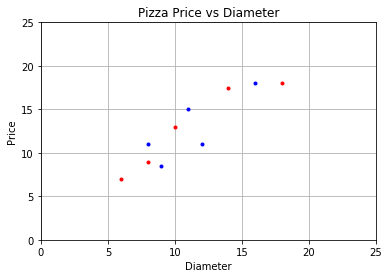

In [6]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

xTrain = np.array([6, 8, 10, 14, 18])[:, np.newaxis]       # 训练数据(直径)
yTrain = np.array([7, 9, 13, 17.5, 18])                    # 训练数据(价格)
xTest = np.array([8, 9, 11, 16, 12])[:, np.newaxis]        # 测试数据(直径)
yTest = np.array([11, 8.5, 15, 18, 11])                    # 测试数据(价格)
plotData = np.array(np.linspace(0, 26, 100))[:,np.newaxis]          # 作图用的数据点

def initPlot():
    plt.figure()
    plt.title('Pizza Price vs Diameter')
    plt.xlabel('Diameter')
    plt.ylabel('Price')
    plt.axis([0, 25, 0, 25])
    plt.grid(True)
    return plt

plt = initPlot()
plt.plot(xTrain, yTrain, 'r.')          # 训练点数据(红色)
plt.plot(xTest, yTest, 'b.')            # 测试点数据(蓝色)

>**步骤2：一阶(线性)拟合实现**

线性拟合R方: 0.6620052929422553


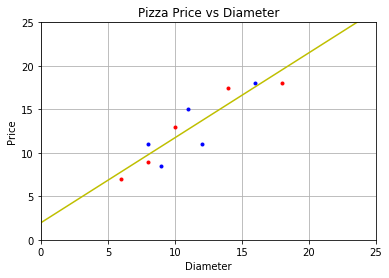

In [7]:
from sklearn.linear_model import LinearRegression

# 线性拟合
linearModel = LinearRegression()             
linearModel.fit(xTrain, yTrain)  
linearModelTrainResult = linearModel.predict(plotData)

# 计算R方
linearModelRSquare = linearModel.score(xTest, yTest)

print("线性拟合R方:", linearModelRSquare)

plt = initPlot()
plt.plot(xTrain, yTrain, 'r.')          # 训练点数据(红色)
plt.plot(xTest, yTest, 'b.')            # 测试点数据(蓝色)
plt.plot(plotData, linearModelTrainResult, 'y-')           # 线性拟合线

> **步骤3：二阶曲线拟合**
* *PolynomialFeatures.fit_transform*提供了将1阶数据扩展到高阶数据的方法
* 训练样本和测试样本都需要进行扩充

[[  1.   6.  36.]
 [  1.   8.  64.]
 [  1.  10. 100.]
 [  1.  14. 196.]
 [  1.  18. 324.]]
二阶拟合R方: 0.4853914100941126


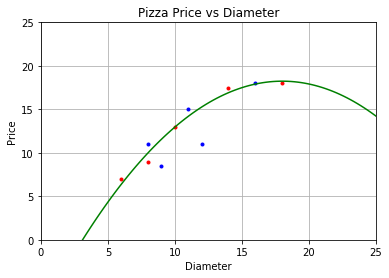

In [8]:
from sklearn.preprocessing import PolynomialFeatures

# 二阶曲线拟合  theta0 + theta1*x + theta2*x*x   x*x => z     theta0+theta1*x+theta2*z
quadratic_featurizer = PolynomialFeatures(degree=2)
xTrain_quadratic = quadratic_featurizer.fit_transform(xTrain)
print(xTrain_quadratic)    # 查看扩展后的特征矩阵
quadraticModel = LinearRegression()
quadraticModel.fit(xTrain_quadratic, yTrain)

# 计算R方(针对测试数据)
xTest_quadratic = quadratic_featurizer.fit_transform(xTest)
quadraticModelRSquare = quadraticModel.score(xTest_quadratic, yTest)
print("二阶拟合R方:", quadraticModelRSquare)

# 绘图点也同样需要进行高阶扩充以便使用曲线进行拟合
plotData_quadratic = quadratic_featurizer.fit_transform(plotData)
quadraticModelTrainResult = quadraticModel.predict(plotData_quadratic)

plt = initPlot()
plt.plot(xTrain, yTrain, 'r.')          # 训练点数据(红色)
plt.plot(xTest, yTest, 'b.')            # 测试点数据(蓝色)
plt.plot(plotData, quadraticModelTrainResult, 'g-')        # 二阶拟合线
plt.show()

> **步骤4：二阶曲线拟合**

三阶拟合R方: 0.47996105393866273


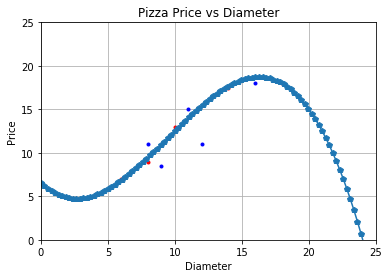

In [9]:
# 三阶曲线拟合
cubic_featurizer = PolynomialFeatures(degree=3)
xTrain_cubic = cubic_featurizer.fit_transform(xTrain)
cubicModel = LinearRegression()
cubicModel.fit(xTrain_cubic, yTrain)
plotData_cubic = cubic_featurizer.fit_transform(plotData)
cubicModelTrainResult = cubicModel.predict(plotData_cubic)


# 计算R方(针对测试数据)
xTest_cubic = cubic_featurizer.fit_transform(xTest)
cubicModelRSquare =  cubicModel.score(xTest_cubic, yTest)
print("三阶拟合R方:", cubicModelRSquare)

plt = initPlot()
plt.plot(xTrain, yTrain, 'r.')          # 训练点数据(红色)
plt.plot(xTest, yTest, 'b.')            # 测试点数据(蓝色)
plt.plot(plotData, cubicModelTrainResult, 'p-')            # 三阶拟合线
plt.show()

### **bias和variance**
观察下列拟合（单变量）:  
![](../images/070402.png)
* 左边图采用直线拟合，很显然有许多训练数据点不能很好的被拟合，将导致训练数据的残差很大。这种情况称为**underfit（欠拟合）**，或者：**High bias**
* 右边图采用4次曲线拟合，完美的通过了训练数据的每个点。但是，如果针对另一批测试数据做预测，这条高阶曲线将产生非常大的误差。这种情况称为**overfit（过拟合）**,或者：**High variance**
* 中间图采用2次曲线拟合，虽然不能完美拟合每个数据点，但是对测试数据也能产生较好的预测效果。这时比较合适的情形
* 因此，在计算模型参数时，既要防止High bias，也要防止High variance